# Principal Component Analysis (PCA)

### What Is PCA?

PCA is a **linear** dimensionality-reduction technique that *rotates* the data into a new coordinate system. In the new coordinate system, the first axis (i.e., principal component 1) captures the largest variance. Each subsequent axis captures the largest remaining variance.

The idea is to **compress** high-dimensional data while losing as little information as possible by projecting onto the top-variance directions.

---

### How It Works

Conceptual algorithm (Eckart–Young):

1. **Standardize & center** the data matrix $X\in\mathbb{R}^{n\times p}$.

2. **Compute covariance** $ \Sigma = \tfrac{1}{n-1} X^\top X$.

3. **Eigenvalue Decomposition (or Singular Value Decompositon) **

   $$
   \Sigma = V\Lambda V^\top,\qquad \text{or } X = U\Sigma V^\top.
   $$

   *Columns of* $V$ (*right singular vectors*) are principal directions; diagonal $\Lambda$ holds variances $\lambda_j$.

4. **Sort** eigenvalues in a descending order $\lambda_1 \ge \lambda_2 \ge \dots \ge \lambda_p$.

5. **Select the top $d$ components** (keep enough to explain a chosen proportion of variance).

6. **Project** data to low-dimensional space: $ Z = X V_{1:d}$.

---
### Some terminologies

- PC loadings are correlation of each variable with the corresponding principal components  

- PC scores describe where each data point falls along that one PC, and they are entries in each PC.  

---

### Pros and Cons

✅ Great for **noise filtering**, compression, and pre-whitening before clustering or regression.  
✅ Removes feature **multicollinearity**; boosts linear model stability.  
✅ Scree plot / variance ratio offers a **data-driven** way to pick dimensionality.  

❌ **Linear**—misses curved manifolds unless you switch to kernel variants.  
❌ **Interpretability** can suffer: loadings are combinations of many original features.  
❌ Sensitive to **scaling**: always standardize or results skew toward large-variance units.  

---

### Key Hyper-parameters (`sklearn.decomposition.PCA`)

| Symbol in `sklearn` | Meaning                                        | Typical starter value                   |
| ------------------- | ---------------------------------------------- | --------------------------------------- |
| `n_components`      | # PCs or variance fraction to keep             | `0.9` (90 % var) or integer             |
| `svd_solver`        | `"auto"`, `"full"`, `"randomized"`, `"arpack"` | `"auto"` (delegates)                    |
| `whiten`            | Scale PCs to unit variance                     | `False` (set `True` for some ML models) |


---


We will use the spotify rating data (only using the numeric variables) to illustrate the use of PCA. 

In [1]:
# Loading data
import pandas as pd

#    (replace path with your own .csv or DataFrame source)
spotify = pd.read_csv("../data/spotify_track_ratings.csv")
spotify= spotify.sample(n=5_000, random_state=42)   
# ▸ Keep just numeric audio columns
num_cols = [
    "danceability", "energy", "loudness", "speechiness",
    "acousticness", "instrumentalness", "liveness",
    "valence", "tempo", "duration_ms"
]
X = spotify[num_cols].dropna()

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 2. Standardise: PCA assumes zero-mean / unit-variance
X_std = StandardScaler().fit_transform(X)

# 3. Fit PCA on the scaled matrix
pca = PCA().fit(X_std)



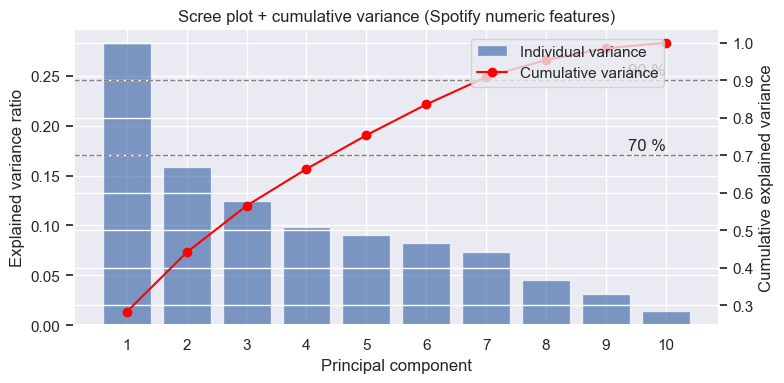

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()

# ---  PLOT  -----------------------------------------------------------
expl_var   = pca.explained_variance_ratio_
cum_var    = expl_var.cumsum()
pcs        = range(1, len(expl_var) + 1)

fig, ax1 = plt.subplots(figsize=(8, 4))

# bars = variance per PC
ax1.bar(pcs, expl_var, alpha=0.7, label="Individual variance")
ax1.set_xlabel("Principal component")
ax1.set_ylabel("Explained variance ratio")
ax1.set_xticks(pcs)

# secondary y-axis for cumulative curve
ax2 = ax1.twinx()
ax2.plot(pcs, cum_var, color="red", marker="o", label="Cumulative variance")
ax2.set_ylabel("Cumulative explained variance")

# horizontal helper lines (e.g. 70 %, 90 %)
for thresh in [0.7, 0.9]:
    ax2.axhline(thresh, ls="--", lw=1, color="grey")
    ax2.text(len(pcs), thresh + 0.015, f"{thresh*100:.0f} %", ha="right")

# legends & title
fig.legend(loc="upper right", bbox_to_anchor=(0.85, 0.9))
plt.title("Scree plot + cumulative variance (Spotify numeric features)")
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

pc_scores   = pca.transform(X_std)[:, :2]          # first 2 PCs
loadings_2d = pca.components_.T[:, :2]             # feature loadings
df_plot = pd.DataFrame(pc_scores, columns=["PC1", "PC2"])

fig = px.scatter(
    df_plot, x="PC1", y="PC2",
    opacity=0.3,
    title="PC 1 vs PC 2 for Spotify numeric features",
    width=800, height=600
)
# Disable all hover interactions
fig.update_traces(hoverinfo="skip", hovertemplate=None)

# Add loading vectors as arrows
arrow_scale = 3.0          # adjust arrow length if needed

for vec, feat in zip(loadings_2d, num_cols):
    x_end, y_end = vec * arrow_scale
    fig.add_shape(
        type="line",
        x0=0, y0=0, x1=x_end, y1=y_end,
        line=dict(color="black", width=1.5)
    )
    fig.add_annotation(
        x=x_end * 1.08, y=y_end * 1.08,
        text=feat,
        showarrow=False,
        font=dict(size=14)   # <— larger font size
    )

# Axis styling
fig.update_layout(
    xaxis_title="PC 1",
    yaxis_title="PC 2",
    xaxis=dict(zeroline=True, zerolinecolor="lightgrey"),
    yaxis=dict(zeroline=True, zerolinecolor="lightgrey"),
)

fig.show()
